In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for graphs and visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# to evaluate machine learning models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**Exploratory analysis**

In [2]:
#load the training data and get summary statistics
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
print(train_data.describe())
print(train_data.isnull().sum())
train_data.head()
print('-------------------------------------')

# load the test set
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
print(test_data.describe())
test_data.head()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex  

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**baseline accuracy:** this is a classification problem with 2 outcomes life or death. we see that the survival rate was ~38.4% which give a Zero Rate classifier of 61.6% as our baseline accuracy. 

we notice that there are a large number of missing Cabin numbers, that we are missing about 1/5 of the ages, and embarkation data from 2 passengers

In [3]:
#get value counts for categorical* data columns
print(train_data['Pclass'].value_counts())
print(train_data['Sex'].value_counts())
print(train_data['SibSp'].value_counts())
print(train_data['Parch'].value_counts())
print(train_data['Embarked'].value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


we can see that the majority of passengers are 3rd class, male, traveling alone, and embarked at port 'S'

In [4]:
# lets convert sex to a numerical variable to work with it more easily
train_data['isMale'] = pd.get_dummies(train_data['Sex'], drop_first= True)
test_data['isMale'] = pd.get_dummies(test_data['Sex'], drop_first= True)

# we are only missing 2 values from the 'Embarked' column. since nearly 72% of passengers embarked at 'S',
# will will fill the missing values with 'S'
train_data['Embarked']=train_data['Embarked'].fillna('S')
test_data['Embarked']=test_data['Embarked'].fillna('S')

# lets get some dummer variables for the 'Embarked' column
train_data[['Embarked_C','Embarked_Q','Embarked_S']]= pd.get_dummies(train_data['Embarked'])
test_data[['Embarked_C','Embarked_Q','Embarked_S']]= pd.get_dummies(test_data['Embarked'])

#lets check that this looks right
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMale,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,1,0,0,1


<AxesSubplot:>

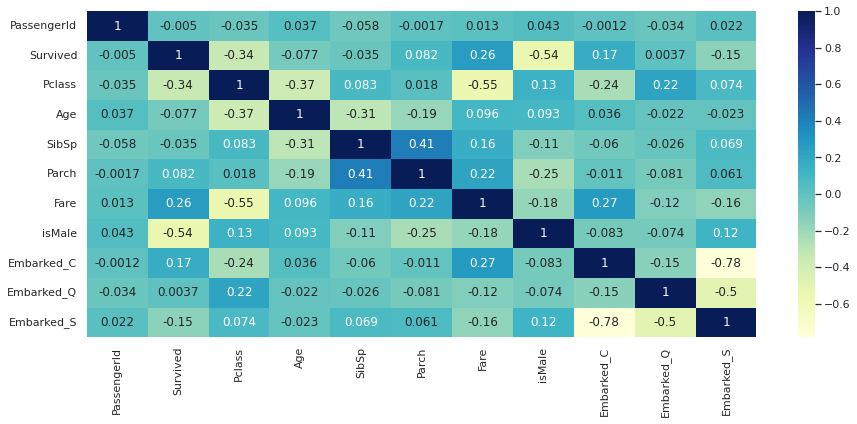

In [5]:
#build a correlation heatmap so that we can see what variables are correlated, specifically to survival
sns.set(rc = {'figure.figsize':(15,6)})
sns.heatmap(train_data.corr(), cmap= 'YlGnBu', annot=True)

-from the heat map we can see that the following variables are highly correlated to survival: Sex,ticket class, fare, and whether you embarked at 'C' (Cherbourg)

-Sex appears to be the most important predictor of survival. and that sex is correlated with ticket class and the number of family members you have on board

-ticket class is second most important factor and seems to be correlated with age


**taking a closer look at some of these relationships**

the survival rate for woman was:  0.7420382165605095
the survival rate for men was:  0.18890814558058924


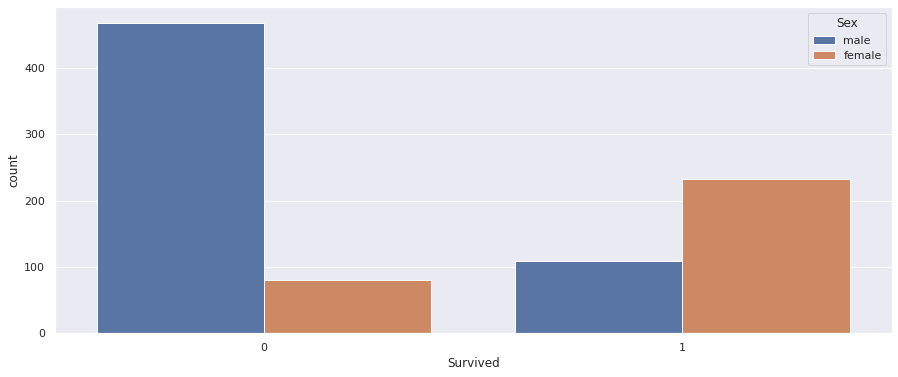

In [6]:
#visualizing some of the relationships. 
sns.countplot(x = 'Survived', hue = 'Sex', data = train_data)

# check for the proportion of women that survived
women = train_data.loc[train_data.Sex=='female']['Survived']
rate_women = sum(women)/len(women)
print('the survival rate for woman was: ', rate_women)

# check for the proportion of men that survived
men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)
print('the survival rate for men was: ', rate_men)

we can see that the vast majority of women survived, and the vast majority of men parished

**How much of a difference does class make?**

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


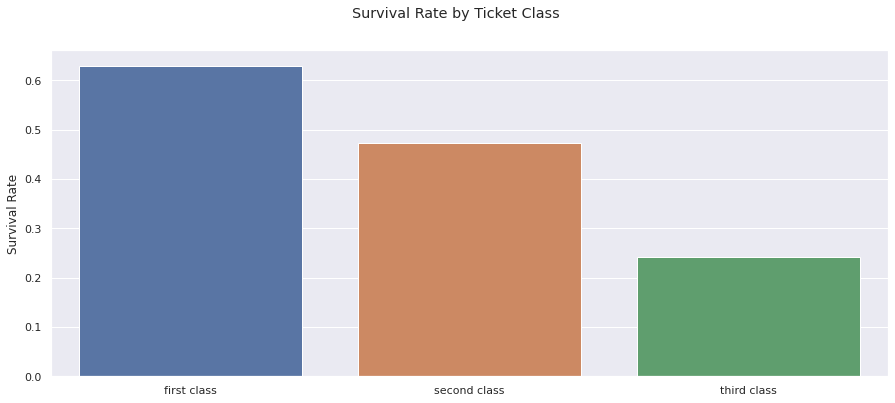

In [7]:
#graph survival rate by class
cls1,cls2,cls3 = train_data.groupby(['Pclass'])['Survived'].mean()
fig, ax = plt.subplots()
sns.barplot( x = ['first class','second class', 'third class'], y = [cls1,cls2,cls3])
ax.set_ylabel('Survival Rate')
fig.suptitle('Survival Rate by Ticket Class')
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

we can see that class had a significant impact of survival rate. We also noticed that there was a correlation between sex and ticket class, so lets make sure this isnt just due to sex.

               Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447


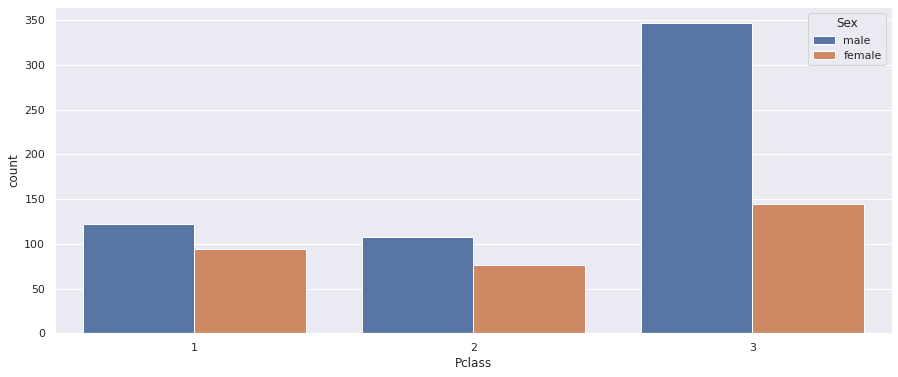

In [8]:
sns.countplot( x = 'Pclass', hue = 'Sex', data = train_data)
print(train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean())

-interestingly, we notice that the survival rate for 1st and second class women is high in the low 90% rannge while women in 3rd class only had  approximately 50% survival rate. 
-while the survival rate of men in 2nd and 3rd class was around 15% but 1st class men had a survival rate of just under 37%, more than 2x as likely to survive. 
we conclude that the survival of higher class passengers is not solely due to gender distribution

 **Although ticket class is correlated with Fare, there is a wide range of fares paid. does this make a diffrence?**

Text(0.5, 0.98, 'Survival Rate by Ticket Class')

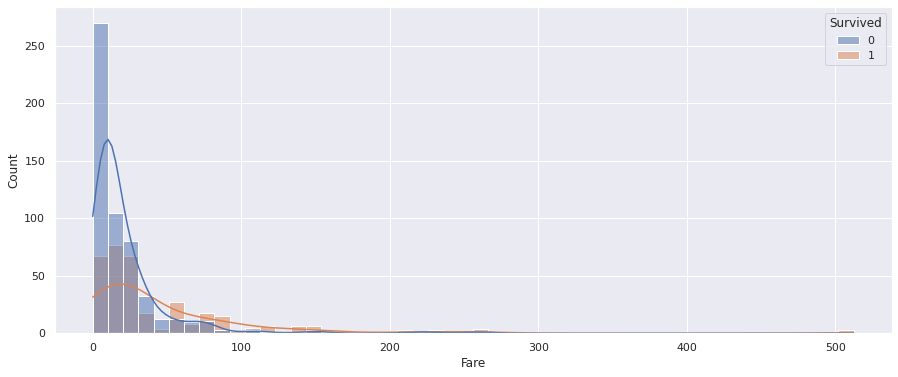

In [9]:
sns.histplot(x = 'Fare', bins = 50, data = train_data, kde = True, hue = 'Survived')
fig.suptitle('Survival Rate by Ticket Class')

it would appear that fare is even more dramatically related to survival rate than is class with the lowest ticket prices resulting in almost certain death and the highest ticket prices having incredibly high survival rates. lets take a look at the breakdown of 1st class ticket prices and see if it made a difference

In [10]:
print(train_data[['Fare','Pclass','Survived']].groupby(['Pclass']).mean())
low_1 = train_data[(train_data['Fare'] <40)&(train_data['Pclass']==1)]
med_1 = train_data[(train_data["Fare"]>=40)&(train_data["Fare"]<80)&(train_data['Pclass']==1)]
high_1 = train_data[(train_data['Fare'] >= 80)&(train_data['Pclass']==1)]

print('there were ',low_1['Survived'].count(), ' 1st class passengers who paid less than $40 and their survival rate was: '\
      ,low_1['Survived'].mean())
print('there were ',med_1['Survived'].count(), ' 1st class passengers who paid between $40 and $80, their survival rate was: '\
      ,med_1['Survived'].mean())
print('there were',high_1['Survived'].count(), ' 1st class passengers who paid more than $80 and their survival rate was: '\
      ,high_1['Survived'].mean())
print('-------------------------------------------------------------------------')

low_2 = train_data[(train_data['Fare'] <14)&(train_data['Pclass']==2)]
med_2 = train_data[(train_data["Fare"]>=14)&(train_data["Fare"]<27)&(train_data['Pclass']==2)]
high_2 = train_data[(train_data['Fare'] >= 27)&(train_data['Pclass']==2)]

print('there were ',low_2['Survived'].count(), ' 2nd class passengers who paid less than $14 and their survival rate was: '\
      ,low_2['Survived'].mean())
print('there were ',med_2['Survived'].count(), ' 2nd class passengers who paid between $14 and $30, their survival rate was: '\
      ,med_2['Survived'].mean())
print('there were',high_2['Survived'].count(), ' 2nd class passengers who paid more than $30 and their survival rate was: '\
      ,high_2['Survived'].mean())
print('-------------------------------------------------------------------------')

low_3 = train_data[(train_data['Fare'] <8)&(train_data['Pclass']==3)]
med_3 = train_data[(train_data["Fare"]>=8)&(train_data["Fare"]<13)&(train_data['Pclass']==3)]
high_3 = train_data[(train_data['Fare'] >= 13)&(train_data['Pclass']==3)]

print('there were ',low_3['Survived'].count(), ' 3rd class passengers who paid less than $8 and their survival rate was: '\
      ,low_3['Survived'].mean())
print('there were ',med_3['Survived'].count(), ' 3rd class passengers who paid between $8 and $13, their survival rate was: '\
      ,med_3['Survived'].mean())
print('there were',high_3['Survived'].count(), ' 3rd class passengers who paid more than $13 and their survival rate was: '\
      ,high_3['Survived'].mean())

             Fare  Survived
Pclass                     
1       84.154687  0.629630
2       20.662183  0.472826
3       13.675550  0.242363
there were  70  1st class passengers who paid less than $40 and their survival rate was:  0.45714285714285713
there were  70  1st class passengers who paid between $40 and $80, their survival rate was:  0.6428571428571429
there were 76  1st class passengers who paid more than $80 and their survival rate was:  0.7763157894736842
-------------------------------------------------------------------------
there were  91  2nd class passengers who paid less than $14 and their survival rate was:  0.3626373626373626
there were  60  2nd class passengers who paid between $14 and $30, their survival rate was:  0.5833333333333334
there were 33  2nd class passengers who paid more than $30 and their survival rate was:  0.5757575757575758
-------------------------------------------------------------------------
there were  229  3rd class passengers who paid less t

We can see that even within each ticket class, passengers that paid more were more likely to survive. this effect was most pronounced amongst 1st and 2nd class passengers

**Does age make a difference?**

Text(0.5, 1.0, 'Survival by Age')

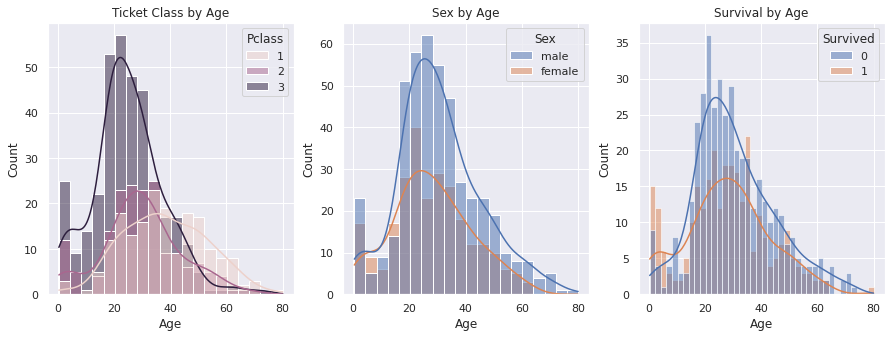

In [11]:
# taking a look at the age distribution 
fix, ax = plt.subplots(1,3,figsize = (15,5), sharex = True)
sns.histplot(ax = ax[0], x = 'Age', bins = 20, kde = True, hue = 'Pclass', data = train_data)
sns.histplot(ax = ax[1], x = 'Age', bins = 20, kde = True, hue = 'Sex', data = train_data)
sns.histplot(ax = ax[2], x = 'Age', bins = 40, kde = True, hue = 'Survived', data = train_data)
ax[0].set_title('Ticket Class by Age')
ax[1].set_title('Sex by Age')
ax[2].set_title('Survival by Age')

- we can see that the age distribution is different by ticket class with 3rd class being the youngest and 1st class being the oldest
- we can see that the age distribution of men and women is very similar but with men being very slightly older on average
- we can see that survival rate was very different for different age groups. children under 6 had a relatively high survival rate, where as people ages 16-25 had a much poorer survival rate. 

In [12]:
# lets try imputing our missing values for age
print('the average age by ticket class:')
print(train_data.groupby(['Pclass','Sex'])['Age'].mean())
print('-----------------------------------------------')
train_data.loc[ (train_data['Pclass'] == 1) & (train_data['Age'].isnull()), 'Age'] = 38
test_data.loc[ (test_data['Pclass'] == 1) & (test_data['Age'].isnull()), 'Age'] = 38
train_data.loc[ (train_data['Pclass'] == 1) & (train_data['Age'].isnull()), 'Age'] = 38
test_data.loc[ (test_data['Pclass'] == 1) & (test_data['Age'].isnull()), 'Age'] = 38



train_data.loc[ (train_data['Pclass'] == 2) & (train_data['Age'].isnull()), 'Age'] = 30
test_data.loc[ (test_data['Pclass'] == 2) & (test_data['Age'].isnull()), 'Age'] = 30
train_data.loc[ (train_data['Pclass'] == 3) & (train_data['Age'].isnull()), 'Age'] = 25
test_data.loc[ (test_data['Pclass'] == 3) & (test_data['Age'].isnull()), 'Age'] = 25

the average age by ticket class:
Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64
-----------------------------------------------


([<matplotlib.axis.XTick at 0x7feb683ba510>,
 [Text(0, 0, '0-6'),
  Text(1, 0, '7-10'),
  Text(2, 0, '11-15'),
  Text(3, 0, '16-25'),
  Text(4, 0, '26-33'),
  Text(5, 0, '34-46'),
  Text(6, 0, '47-55'),
  Text(7, 0, 'over 55')])

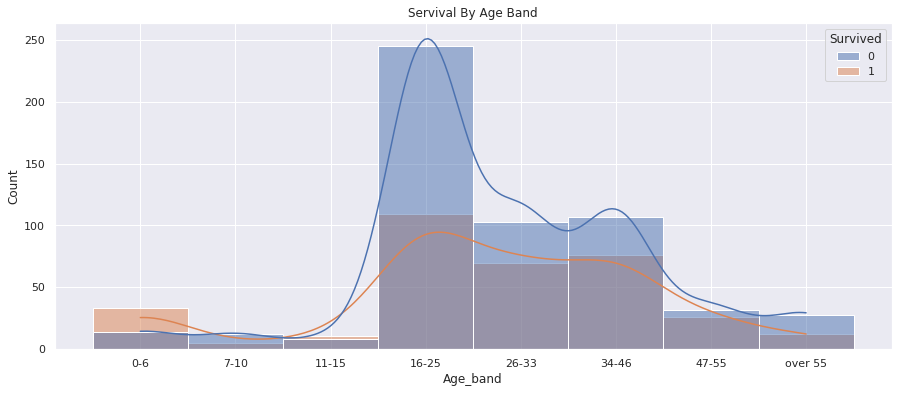

In [13]:
# we notice that different age groups have different odds of survival, so lets create some age bands
train_data.loc[ train_data['Age'] <= 6, 'Age_band'] = 0
train_data.loc[(train_data['Age'] > 6) & (train_data['Age'] <= 10), 'Age_band'] = 1
train_data.loc[(train_data['Age'] > 10) & (train_data['Age'] <= 15), 'Age_band'] = 2
train_data.loc[(train_data['Age'] > 15) & (train_data['Age'] <= 25), 'Age_band'] = 3
train_data.loc[(train_data['Age'] > 25) & (train_data['Age'] <= 33), 'Age_band'] = 4
train_data.loc[(train_data['Age'] > 33) & (train_data['Age'] <= 46), 'Age_band'] = 5
train_data.loc[(train_data['Age'] > 46) & (train_data['Age'] <= 55), 'Age_band'] = 6
train_data.loc[(train_data['Age'] > 55), 'Age_band'] = 7

test_data.loc[ test_data['Age'] <= 6, 'Age_band'] = 0
test_data.loc[(test_data['Age'] > 6) & (test_data['Age'] <= 10), 'Age_band'] = 1
test_data.loc[(test_data['Age'] > 10) & (test_data['Age'] <= 15), 'Age_band'] = 2
test_data.loc[(test_data['Age'] > 15) & (test_data['Age'] <= 25), 'Age_band'] = 3
test_data.loc[(test_data['Age'] > 25) & (test_data['Age'] <= 33), 'Age_band'] = 4
test_data.loc[(test_data['Age'] > 33) & (test_data['Age'] <= 46), 'Age_band'] = 5
test_data.loc[(test_data['Age'] > 46) & (test_data['Age'] <= 55), 'Age_band'] = 6
test_data.loc[(test_data['Age'] > 55), 'Age_band'] = 7

sns.histplot( x = 'Age_band', bins = 8, kde = True, hue = 'Survived', data = train_data, discrete = True).set(title='Servival By Age Band')
plt.xticks([0,1,2,3,4,5,6,7],['0-6','7-10','11-15','16-25','26-33','34-46','47-55','over 55'])

we can see that the survival rates of different age bands looks very different. this will likely be a better predictor than age which may contain too much noise to be useful. 

**Did having family members on board help?** 

<AxesSubplot:xlabel='Parch', ylabel='Count'>

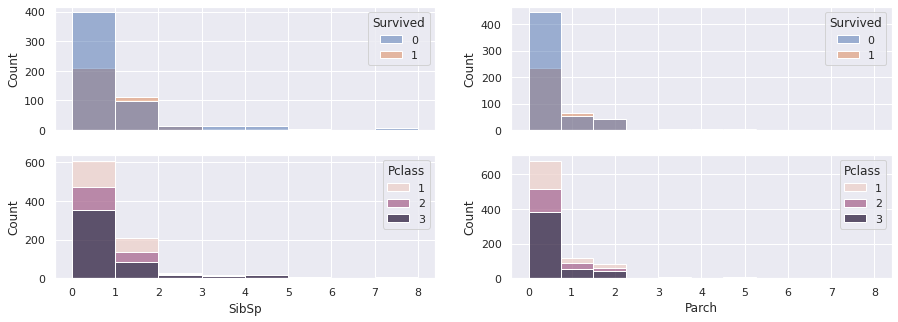

In [14]:
# did having family members on board increase your odds of survival
fix, ax = plt.subplots(2,2,figsize = (15,5), sharex = True)
sns.histplot(ax = ax[0][0],x = 'SibSp', bins = 8, data = train_data, hue = 'Survived')
sns.histplot(ax = ax[0][1],x = 'Parch', bins = 8, data = train_data, hue = 'Survived')
# was family size influenced by ticket class
sns.histplot(ax = ax[1][0],x = 'SibSp', bins = 8, data = train_data, hue = 'Pclass', multiple="stack")
sns.histplot(ax = ax[1][1],x = 'Parch', bins = 8, data = train_data, hue = 'Pclass', multiple="stack")

it appears that 1st class passengers were more likely to be traveling with a single sibling or spouse. 
It also appears that having a family member or two on board increased your chances of survival, lets create a new feature to track total number of family members on board 

The max number of family members on board was:  10


<AxesSubplot:xlabel='Fmembers', ylabel='Count'>

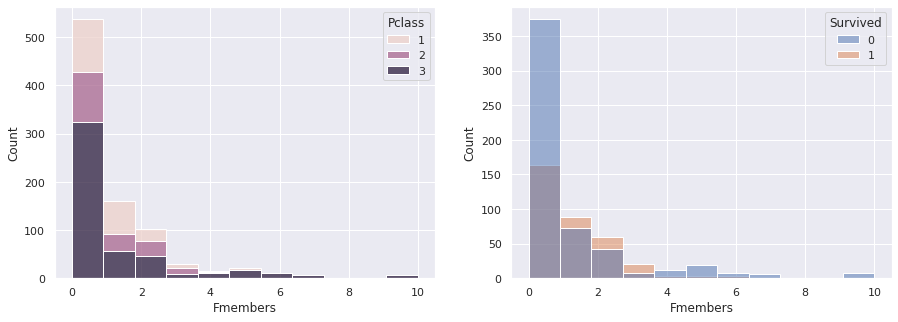

In [15]:
# create a new column for total number of family members on board and see if this impacts survival for each Pclass
train_data['Fmembers']= train_data['Parch']+train_data['SibSp']
test_data['Fmembers']= test_data['Parch']+test_data['SibSp']
print('The max number of family members on board was: ', max(train_data['Fmembers']))
fix, ax = plt.subplots(1,2,figsize = (15,5), sharex = True)
sns.histplot(ax = ax[0],x = 'Fmembers', bins = 11, data = train_data, hue = 'Pclass', multiple="stack")
sns.histplot(ax = ax[1],x = 'Fmembers', bins = 11, data = train_data, hue = 'Survived')

it appears that your odds of survival were better than 50/50 if you had between 1 and 3 family members on board with you. 

**does embarkation port make a difference?**

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

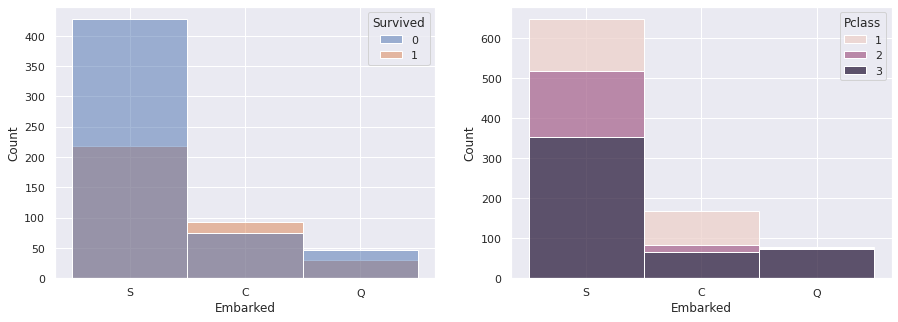

In [16]:
# did embarkation port make a difference?
fix, ax = plt.subplots(1,2,figsize = (15,5), sharex = True)
sns.histplot(ax = ax[0],x = 'Embarked', bins = 3, data = train_data, hue = 'Survived')
sns.histplot(ax = ax[1],x = 'Embarked', bins = 3, data = train_data, hue = 'Pclass', multiple="stack")
# we can see that people embarking at C were most likely to survive... but where also most likely to be 1st class

the survival rate for passengers from C is quite high while that of S is quite low. We notice that the survival rate is similar to the proportion of higher class ticket holders embarking from each port. We also notice that at port Q, only 3rd class passengers boardded, but that their survival rate was higher than 3rd class passengers overall making 'embarked' a valueble feature to include. 

In [17]:
# drop cabin as so many are missing, and double check to make sure there are no other missing values
train_data= train_data.drop('Cabin', axis = 1)
test_data= test_data.drop('Cabin', axis = 1)
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# missing one passengers 'Fare'  we will replace with the average for their ticker class. 
test_data['Fare'].fillna(test_data[test_data['Pclass']==3]['Fare'].mean(), inplace = True)
print(test_data.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
isMale         0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Age_band       0
Fmembers       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
isMale         0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Age_band       0
Fmembers       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
isMale         0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Age_band       0
Fmembers       0
dtype: int64


**Predictive models**

 as features, I have elected to use sex, class, fare, age, family members and embarkation port. 
 the last feature I did not intend to use as I thought it would be too closely correlated with class, but including it
 increased my model accuracy.

In [18]:
# create target column, select features, and make dummy variables where needed.  
y= train_data['Survived']

features = ['isMale', 'Pclass', 'Age_band','Fmembers', 'Embarked', 'Fare']
X = pd.get_dummies(train_data[features])
print(X.head())
X_test = pd.get_dummies(test_data[features])
print(X_test.head())

   isMale  Pclass  Age_band  Fmembers     Fare  Embarked_C  Embarked_Q  \
0       1       3       3.0         1   7.2500           0           0   
1       0       1       5.0         1  71.2833           1           0   
2       0       3       4.0         0   7.9250           0           0   
3       0       1       5.0         1  53.1000           0           0   
4       1       3       5.0         0   8.0500           0           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1  
   isMale  Pclass  Age_band  Fmembers     Fare  Embarked_C  Embarked_Q  \
0       1       3       5.0         0   7.8292           0           1   
1       0       3       6.0         1   7.0000           0           0   
2       1       2       7.0         0   9.6875           0           1   
3       1       3       4.0         0   8.6625           0           0   
4       0       3       3.0         2  12.2875           0           0   

   Embarked_S 

we will start out with a logistic regression model. we will use gridsearch CV for hyperperameter tuning, but will comment this out after I run it for computational efficiency. 

In [19]:

logreg = LogisticRegression()

# params = [{'solver': ['liblinear', 'saga'],
#         'penalty': ['none','l1', 'l2', 'elasticnet'],
#          'C': [100, 10, 1.0, 0.1, 0.01]}]
# gs_logreg = GridSearchCV(logreg,
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)
# gs_logreg.fit(X, y)
# print('best params' , gs_logreg.best_params_)

# logreg.fit(X,y)
# logred_pred = logreg.predict(X_test)
# scores = cross_val_score(logreg, X, y, cv=5)
# print('accuracy score:' , round(logreg.score(X, y) * 100, 2))
# print(scores)
# print(scores.mean())

logreg = LogisticRegression(C = 10, penalty = 'l2', solver= 'liblinear')
logreg.fit(X,y)
logred_pred = logreg.predict(X_test)
scores = cross_val_score(logreg, X, y, cv=5)
print('accuracy score:' , round(logreg.score(X, y) * 100, 2))
print(scores)
scores.mean()

accuracy score: 80.47
[0.77653631 0.8258427  0.79775281 0.79213483 0.82022472]


0.8024982738057875

we can see that the accuracy and 5 fold validation score are both around 80%, which is an imporovement over our 62% baseline attained from guessing all parished.

In [20]:
# find correlation coefficients using the logistic regression            
pd.DataFrame(logreg.coef_[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=True)

,coef
isMale,-2.742358
Pclass,-1.155372
Age_band,-0.381992
Fmembers,-0.260242
Fare,0.002530
Embarked_S,1.191800
Embarked_Q,1.364038
Embarked_C,1.559418


we can see that fare is the perameter which is the least strongly correlated with an outcome. 

next, we will train a random forest classifier. during hypertuning of perameters, we found that including all 7 features (including fare) we got the best results, so I chose not to remove this from the list of features used. 

In [21]:
RandFor = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

# params = [{'max_features': [4,5,6,7,8],
#          'n_estimators': [10,20,30,50],
#           'max_depth' : [3,4,5,6,8]}]
# gs_RandFor = GridSearchCV(RandFor,
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)

# gs_RandFor.fit(X, y)
# print('best params' , gs_RandFor.best_params_)

# RandFor.fit(X,y)
# RandFor_pred = RandFor.predict(X_test)
# print('accuracy score:' , round(knn.score(X_norm, y) * 100, 2))
# scores = cross_val_score(RandFor, X, y, cv=5)
# print(scores)
# print(scores.mean())

RandFor = RandomForestClassifier(max_depth = 4, max_features= 7, n_estimators= 100)
RandFor.fit(X,y)
RandFor_pred = RandFor.predict(X_test)
scores = cross_val_score(RandFor, X, y, cv=5)
print('accuracy score:' , round(RandFor.score(X, y) * 100, 2))
print(scores)
scores.mean()

accuracy score: 83.61
[0.82122905 0.80898876 0.82022472 0.79213483 0.85393258]


0.8193019898311469

here we can see that the random forst classifier's performance was a bit better than the logistic regression with an accuracy of around 83%

finaly, we will train a nearest neighbors classifier. 

In [22]:
knn = KNeighborsClassifier()
X_norm=(X-X.mean())/X.std()
X_norm_test=(X_test-X_test.mean())/X_test.std()

# params = [{'n_neighbors': [5,10,15,18,19,20,21,22],
#          'metric': ['euclidean', 'manhattan', 'minkowski'],
#           'weights' : ['uniform', 'distance']}]

# gs_knn = GridSearchCV(knn,
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)

# gs_knn.fit(X_norm, y)
# print('best params' , gs_knn.best_params_)

# knn.fit(X_norm,y)
# knn_pred = knn.predict(X_test)
# print('accuracy score:' , round(knn.score(X_norm, y) * 100, 2))
# scores = cross_val_score(knn, X_norm, y, cv=5)
# print(scores)
# print(scores.mean())

knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 20, weights= 'uniform')
knn.fit(X_norm,y)
knn_pred = knn.predict(X_test)
print('accuracy score:' , round(knn.score(X_norm, y) * 100, 2))
scores = cross_val_score(knn, X_norm, y, cv=5)
print(scores)
scores.mean()


accuracy score: 82.38
[0.81005587 0.79213483 0.82022472 0.78651685 0.84831461]


0.8114493754315486

after tuning, this model had an accuracy of less than 82%.
All of our models performed similarly. to see if we can imporve our accuracy further, I will use a voting classifier to make an ensemble of the three algorithms used so far. 

**Now Lets create an Ensemble**

In [23]:
classifiers = [('Logistic Regression', logreg),
              ('Random Forest', RandFor),
              ('knearest neighbors', knn)]
VC = VotingClassifier(estimators = classifiers)
VC.fit(X_norm,y)
y_pred = VC.predict(X_test)
print('accuracy score:' , round(VC.score(X_norm, y) * 100, 2))
scores = cross_val_score(VC, X_norm, y, cv=5)
print(scores)
scores.mean()

accuracy score: 83.73
[0.80446927 0.8258427  0.80898876 0.79775281 0.84831461]


0.8170736300295023

the accuracy of the ensemble was also around 82% and did not outperform our random forest classifier. 

after all the work to create the ensemble, it turns out that the random forest still produces the best results. 

In [24]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': RandFor_pred})
output.to_csv('submission.csv', index=False)
print('predictions sucessfully saved')

predictions sucessfully saved
